# Insight Generation Pipeline

## Import all the important stuff

### General Imports

In [1]:
import os
import getpass

### Langchain Imports

In [2]:
from langchain import hub
from langchain.chat_models import init_chat_model
from langchain_community.utilities import SQLDatabase
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_ollama import ChatOllama

## Database

Both is accessible via db.get_table_info() too but I noticed that the SQL agent had more issue generating appropriate summaries. Once I have looked into this more, setting up the schemas and example rows should be taken care of automatically again.

In [3]:
db_schema = '"\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)"'
db_schema += '\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)'
db_schema += '\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60) NOT NULL, \n\t"SupportRepId" INTEGER, \n\tPRIMARY KEY ("CustomerId"), \n\tFOREIGN KEY("SupportRepId") REFERENCES "Employee" ("EmployeeId")\n)'
db_schema += '\nCREATE TABLE "Employee" (\n\t"EmployeeId" INTEGER NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"FirstName" NVARCHAR(20) NOT NULL, \n\t"Title" NVARCHAR(30), \n\t"ReportsTo" INTEGER, \n\t"BirthDate" DATETIME, \n\t"HireDate" DATETIME, \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60), \n\tPRIMARY KEY ("EmployeeId"), \n\tFOREIGN KEY("ReportsTo") REFERENCES "Employee" ("EmployeeId")\n)'
db_schema += '\nCREATE TABLE "Genre" (\n\t"GenreId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("GenreId")\n)'
db_schema += '\nCREATE TABLE "Invoice" (\n\t"InvoiceId" INTEGER NOT NULL, \n\t"CustomerId" INTEGER NOT NULL, \n\t"InvoiceDate" DATETIME NOT NULL, \n\t"BillingAddress" NVARCHAR(70), \n\t"BillingCity" NVARCHAR(40), \n\t"BillingState" NVARCHAR(40), \n\t"BillingCountry" NVARCHAR(40), \n\t"BillingPostalCode" NVARCHAR(10), \n\t"Total" NUMERIC(10, 2) NOT NULL, \n\tPRIMARY KEY ("InvoiceId"), \n\tFOREIGN KEY("CustomerId") REFERENCES "Customer" ("CustomerId")\n)'
db_schema += '\nCREATE TABLE "InvoiceLine" (\n\t"InvoiceLineId" INTEGER NOT NULL, \n\t"InvoiceId" INTEGER NOT NULL, \n\t"TrackId" INTEGER NOT NULL, \n\t"UnitPrice" NUMERIC(10, 2) NOT NULL, \n\t"Quantity" INTEGER NOT NULL, \n\tPRIMARY KEY ("InvoiceLineId"), \n\tFOREIGN KEY("TrackId") REFERENCES "Track" ("TrackId"), \n\tFOREIGN KEY("InvoiceId") REFERENCES "Invoice" ("InvoiceId")\n)'
db_schema += '\nCREATE TABLE "MediaType" (\n\t"MediaTypeId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("MediaTypeId")\n)\n\n/*\n3 rows from MediaType table:\nMediaTypeId\tName\n1\tMPEG audio file\n2\tProtected AAC audio file\n3\tProtected MPEG-4 video file\n*/\n\n\nCREATE TABLE "Playlist" (\n\t"PlaylistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("PlaylistId")\n)'
db_schema += '\nCREATE TABLE "PlaylistTrack" (\n\t"PlaylistId" INTEGER NOT NULL, \n\t"TrackId" INTEGER NOT NULL, \n\tPRIMARY KEY ("PlaylistId", "TrackId"), \n\tFOREIGN KEY("TrackId") REFERENCES "Track" ("TrackId"), \n\tFOREIGN KEY("PlaylistId") REFERENCES "Playlist" ("PlaylistId")\n)'
db_schema += '\nCREATE TABLE "Track" (\n\t"TrackId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(200) NOT NULL, \n\t"AlbumId" INTEGER, \n\t"MediaTypeId" INTEGER NOT NULL, \n\t"GenreId" INTEGER, \n\t"Composer" NVARCHAR(220), \n\t"Milliseconds" INTEGER NOT NULL, \n\t"Bytes" INTEGER, \n\t"UnitPrice" NUMERIC(10, 2) NOT NULL, \n\tPRIMARY KEY ("TrackId"), \n\tFOREIGN KEY("MediaTypeId") REFERENCES "MediaType" ("MediaTypeId"), \n\tFOREIGN KEY("GenreId") REFERENCES "Genre" ("GenreId"), \n\tFOREIGN KEY("AlbumId") REFERENCES "Album" ("AlbumId")\n)'


In [4]:
db_example_rows = ''
db_example_rows += '/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n'
db_example_rows += '/*\n3 rows from Customer table:\nCustomerId\tFirstName\tLastName\tCompany\tAddress\tCity\tState\tCountry\tPostalCode\tPhone\tFax\tEmail\tSupportRepId\n1\tLuís\tGonçalves\tEmbraer - Empresa Brasileira de Aeronáutica S.A.\tAv. Brigadeiro Faria Lima, 2170\tSão José dos Campos\tSP\tBrazil\t12227-000\t+55 (12) 3923-5555\t+55 (12) 3923-5566\tluisg@embraer.com.br\t3\n2\tLeonie\tKöhler\tNone\tTheodor-Heuss-Straße 34\tStuttgart\tNone\tGermany\t70174\t+49 0711 2842222\tNone\tleonekohler@surfeu.de\t5\n3\tFrançois\tTremblay\tNone\t1498 rue Bélanger\tMontréal\tQC\tCanada\tH2G 1A7\t+1 (514) 721-4711\tNone\tftremblay@gmail.com\t3\n*/\n'
db_example_rows += '/*\n3 rows from Employee table:\nEmployeeId\tLastName\tFirstName\tTitle\tReportsTo\tBirthDate\tHireDate\tAddress\tCity\tState\tCountry\tPostalCode\tPhone\tFax\tEmail\n1\tAdams\tAndrew\tGeneral Manager\tNone\t1962-02-18 00:00:00\t2002-08-14 00:00:00\t11120 Jasper Ave NW\tEdmonton\tAB\tCanada\tT5K 2N1\t+1 (780) 428-9482\t+1 (780) 428-3457\tandrew@chinookcorp.com\n2\tEdwards\tNancy\tSales Manager\t1\t1958-12-08 00:00:00\t2002-05-01 00:00:00\t825 8 Ave SW\tCalgary\tAB\tCanada\tT2P 2T3\t+1 (403) 262-3443\t+1 (403) 262-3322\tnancy@chinookcorp.com\n3\tPeacock\tJane\tSales Support Agent\t2\t1973-08-29 00:00:00\t2002-04-01 00:00:00\t1111 6 Ave SW\tCalgary\tAB\tCanada\tT2P 5M5\t+1 (403) 262-3443\t+1 (403) 262-6712\tjane@chinookcorp.com\n*/\n'
db_example_rows += '/*\n3 rows from Genre table:\nGenreId\tName\n1\tRock\n2\tJazz\n3\tMetal\n*/\n'
db_example_rows += '/*\n3 rows from Invoice table:\nInvoiceId\tCustomerId\tInvoiceDate\tBillingAddress\tBillingCity\tBillingState\tBillingCountry\tBillingPostalCode\tTotal\n1\t2\t2021-01-01 00:00:00\tTheodor-Heuss-Straße 34\tStuttgart\tNone\tGermany\t70174\t1.98\n2\t4\t2021-01-02 00:00:00\tUllevålsveien 14\tOslo\tNone\tNorway\t0171\t3.96\n3\t8\t2021-01-03 00:00:00\tGrétrystraat 63\tBrussels\tNone\tBelgium\t1000\t5.94\n*/\n'
db_example_rows += '/*\n3 rows from InvoiceLine table:\nInvoiceLineId\tInvoiceId\tTrackId\tUnitPrice\tQuantity\n1\t1\t2\t0.99\t1\n2\t1\t4\t0.99\t1\n3\t2\t6\t0.99\t1\n*/\n'
db_example_rows += '/*\n3 rows from MediaType table:\nMediaTypeId\tName\n1\tMPEG audio file\n2\tProtected AAC audio file\n3\tProtected MPEG-4 video file\n*/\n'
db_example_rows += '/*\n3 rows from Playlist table:\nPlaylistId\tName\n1\tMusic\n2\tMovies\n3\tTV Shows\n*/\n'
db_example_rows += '/*\n3 rows from PlaylistTrack table:\nPlaylistId\tTrackId\n1\t3402\n1\t3389\n1\t3390\n*/\n'
db_example_rows += '*\n3 rows from Track table:\nTrackId\tName\tAlbumId\tMediaTypeId\tGenreId\tComposer\tMilliseconds\tBytes\tUnitPrice\n1\tFor Those About To Rock (We Salute You)\t1\t1\t1\tAngus Young, Malcolm Young, Brian Johnson\t343719\t11170334\t0.99\n2\tBalls to the Wall\t2\t2\t1\tU. Dirkschneider, W. Hoffmann, H. Frank, P. Baltes, S. Kaufmann, G. Hoffmann\t342562\t5510424\t0.99\n3\tFast As a Shark\t3\t2\t1\tF. Baltes, S. Kaufman, U. Dirkscneider & W. Hoffman\t230619\t3990994\t0.99\n*/'

In [5]:
db = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [6]:
db.get_table_info()

'\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from Artist table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/\n\n\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60) NOT NULL, \n\t"SupportRepId" INTEG

## LLM

### Chat

In [7]:
model = ChatOllama(
    model="llama3.2",
    temperature=0,
    # other params...
)

#from langchain_openai import ChatOpenAI
#
#if not os.environ.get("OPENAI_API_KEY"):
#  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")
#
#model = ChatOpenAI(
#    model="gpt-4o",
#    temperature=0,
#    max_tokens=None,
#    timeout=None,
#    max_retries=2,
#    # api_key="...",  # if you prefer to pass api key in directly instaed of using env vars
#    # base_url="...",
#    # organization="...",
#    # other params...
#)

## Prompt Templates

In [8]:
describe_db_template = PromptTemplate.from_file("prompts/describe_db.txt")
# describe_db_template.invoke({"db_schema": db.get_table_info()})

sum_db_template = PromptTemplate.from_file("prompts/sum_db.txt")

high_level_q_template = PromptTemplate.from_file("prompts/generate_high_level_question.txt")
# high_level_q_template.invoke({"tables_description": tables_description})

low_level_q_template = PromptTemplate.from_file("prompts/generate_low_level_question.txt")
# low_level_q_template.invoke({
    # "questions": high_level_q,
    # "schema": db_schema,
    # "tables": table_names,
    # "tables_description": tables_description})

In [9]:
describe_db = "Given the following database create a description of the database in natural text explaining to a user the structure of the table and the data it contains. Avoid html and give raw text with all the explanations. Explain the database, the tables and the columns in each table."
sum_db = "Take the following database description and return a brief (3 lines) description. Your description must contain only a high level description of the database, avoid explaining tables. ### Database description:"
high_level = "Generate ten questions related to a user that works as an analyst from the following has to analyze customer data - what are the customer trends, and what actions might they need to take using data sources. The user works with the following database:"

## Pipeline Magic

In [10]:
from langchain_core.output_parsers import StrOutputParser
from langchain import LLMChain

output_parser = StrOutputParser()

In [11]:
db_prompt = ChatPromptTemplate.from_messages(
    [ 
        ("human", describe_db_template.invoke(
            {
            "db_schema": db_schema,
            "db_example_rows": db_example_rows
            }).to_string())
    ])

chain = db_prompt | model | output_parser 
db_description = chain.invoke({})

sum_db_prompt = ChatPromptTemplate.from_messages(
    [
            ("human", sum_db_template.invoke(
            {
            "db_description": db_description
            }).to_string())
    ])

chain2 = sum_db_prompt | model | output_parser 
db_sum = chain2.invoke({})

high_q_prompt = ChatPromptTemplate.from_messages(
    [ 
        ("human", high_level_q_template.invoke(db_sum).to_string())
    ]
)

chain3 = high_q_prompt | model | output_parser 
high_q = chain3.invoke({})

In [12]:
high_q_list = high_q.splitlines()
for high_q in high_q_list:
    print(high_q)

What are the most popular genres among our customer base based on their listening history?
How do customer demographics (age, location, etc.) impact their music preferences?
Can we identify any seasonal trends in customer behavior or music consumption patterns?
Which employee roles have the highest level of access to sensitive customer data and how can this be optimized?
What is the average revenue per user (ARPU) for our premium subscription tier compared to free users?
How do changes in music content offerings affect customer engagement and retention rates?
Can we use clustering analysis to group customers based on their listening habits and preferences?
Are there any correlations between customer purchase history and their social media activity?
What is the impact of pricing strategies (e.g., discounts, promotions) on customer churn and overall revenue growth?
How can we leverage data from our financial transactions database to identify opportunities for upselling or cross-selling m

In [13]:
low_q_dict = {}
for high_q in high_q_list:
    low_q_list = (low_level_q_template | model | output_parser).invoke(
        {
        "n_questions": 10,
        "question": high_q_list[0],
        "tables": db.get_usable_table_names(),
        "tables_description": db_description
        }
    )
    low_q_list = low_q_list.splitlines()
    low_q_list = list(filter(lambda x: x != "", low_q_list))
    low_q_list = list(filter(lambda x: x != " ", low_q_list))
    low_q_dict[high_q] = low_q_list.copy()

In [14]:
for high_q in high_q_list:
    print(f"{high_q}")
    print(f"Low level questions:")
    for i,low_q in enumerate(low_q_dict[high_q]):
        print(f"{i+1}. {low_q}")
    print("\n")

What are the most popular genres among our customer base based on their listening history?
Low level questions:
1. What is the average number of tracks per album across all albums that belong to the top 5 most popular genres in terms of total track sales? 
2. What is the sum of the total revenue generated by each genre from invoice lines where the unit price is greater than the average unit price of all tracks belonging to that genre?
3. What is the count of customers who have purchased at least one track from a specific genre, grouped by the number of employees assigned to them?
4. What is the average rating given by customers for tracks belonging to the top 5 most popular genres in terms of total track sales?
5. What is the sum of the total number of invoice lines for each media type where the quantity sold is greater than the average quantity sold across all media types?
6. What is the count of albums that have been released within the last year, grouped by the genre(s) they belong 

### SQL Agent
The following code to build an SQL Agent was taken from

https://langchain-ai.github.io/langgraph/tutorials/sql-agent/

There seem to be some issues with execution of the query once an appropriate SQL has been generated.

In [15]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [16]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=model)
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

print(list_tables_tool.invoke(""))

print(get_schema_tool.invoke("Artist"))

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


In [17]:
from langchain_core.tools import tool

@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result


print(db_query_tool.invoke("SELECT * FROM Artist LIMIT 10;"))

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


In [18]:
from langchain_core.prompts import ChatPromptTemplate

query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)
query_check = query_check_prompt | model.bind_tools(
    [db_query_tool], tool_choice="required"
)

query_check.invoke({"messages": [("user", "SELECT * FROM Artist LIMIT 10;")]})

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-04-11T09:11:15.5217407Z', 'done': True, 'done_reason': 'stop', 'total_duration': 374766800, 'load_duration': 19234100, 'prompt_eval_count': 328, 'prompt_eval_duration': 12069600, 'eval_count': 24, 'eval_duration': 341883300, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-f8aaec06-dc75-43a7-9c58-4d610867baf8-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Artist LIMIT 10'}, 'id': 'e88ce604-72b7-44e7-98a9-2475934e29cd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 328, 'output_tokens': 24, 'total_tokens': 352})

In [19]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage

from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages


# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# Define a new graph
workflow = StateGraph(State)


# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }


def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}


workflow.add_node("first_tool_call", first_tool_call)

# Add nodes for the first two tools
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# Add a node for a model to choose the relevant tables based on the question and available tables
model_get_schema = model.bind_tools(
    [get_schema_tool]
)
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)


# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""

    final_answer: str = Field(..., description="The final answer to the user")


# Add a node for a model to generate a query based on the question and schema
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set. 
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""
query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)
query_gen = query_gen_prompt | model.bind_tools(
[SubmitFinalAnswer, model_check_query]
)


def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}


workflow.add_node("query_gen", query_gen_node)

# Add a node for the model to check the query before executing it
workflow.add_node("correct_query", model_check_query)

# Add node for executing the query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))


# Define a conditional edge to decide whether to continue or end the workflow
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is a tool call, then we finish
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


# Specify the edges between the nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Compile the workflow into a runnable
app = workflow.compile()

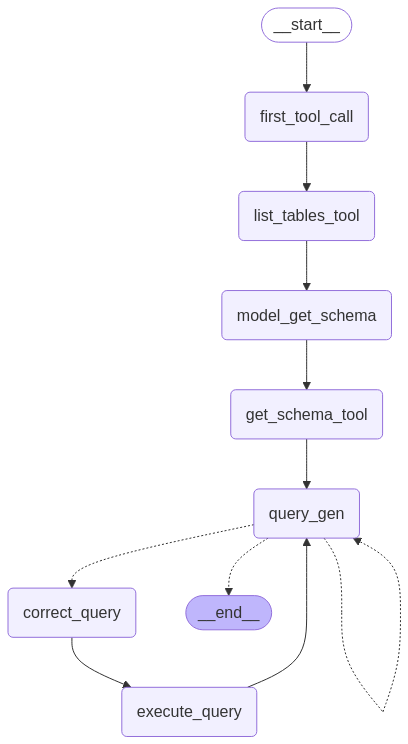

In [20]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [64]:
low_answer_dict = {}
for i, questions in enumerate(low_q_dict.values()):
    messages = []
    answers = []
    json_strs = []
    for question in questions:
        messages.append(app.invoke(
            {"messages": [("user", question)]},
            {"recursion_limit": 50}
        ))
        json_strs.append(messages[-1]["messages"][-1].tool_calls[0]["args"]["final_answer"])
    low_answer_dict[i] = json_strs.copy()

GraphRecursionError: Recursion limit of 50 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [66]:
for event in app.stream(
    {"messages": [("user", low_q_dict[high_q_list[0]][1])]}
    ):
    print(event)

{'first_tool_call': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, id='4191e164-99ca-4de5-8bc1-e34c3638bb91', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}])]}}
{'list_tables_tool': {'messages': [ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='209b0675-0c82-4ef3-aa1a-08b20d1e04bc', tool_call_id='tool_abcd123')]}}
{'model_get_schema': {'messages': [AIMessage(content='Using the `sql` command to get the total revenue for each genre:\n```\nSELECT \n  g.name AS genre_name,\n  SUM(i.total_amount) AS total_revenue\nFROM \n  invoices i\nJOIN \n  invoice_lines il ON i.id = il.invoice_id\nJOIN \n  invoice_items ii ON il.line_id = ii.line_id\nJOIN \n  tracks t ON ii.track_id = t.id\nJOIN \n  genres g ON t.genre_id = g.id\nGROUP BY \n  g.name\nHAVING \n  SUM(i.total_amount) > 0;\n```\nThis query joins th

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

## A more basic (?) SQL agent

In [21]:
from langchain_community.agent_toolkits import create_sql_agent


In [29]:
agent_executor = create_sql_agent(model, db=db)
agent_executor.handle_parsing_errors = True
agent_executor.early_stopping_method = "force"
agent_executor.max_execution_time = 50000

In [30]:
low_answer_dict = {}
for i, questions in enumerate(low_q_dict.values()):
    outputs = []
    for question in questions:
        output = agent_executor.invoke(question)
        outputs.append(output["output"])
    low_answer_dict[i] = outputs.copy()

In [33]:
for i, high_q in enumerate(high_q_list):
    print(f"{high_q}")
    print(f"Low level questions and answers:")
    for j, low_q in enumerate(low_q_dict[high_q]):
        print(f"{j+1}. {low_q}")
        print(f"Answer: {low_answer_dict[i][j]}")
    print("\n")
    

What are the most popular genres among our customer base based on their listening history?
Low level questions and answers:
1. What is the average number of tracks per album across all albums that belong to the top 5 most popular genres in terms of total track sales? 
Answer: SELECT 'The final answer is $\\boxed{[answer]}$.' AS answer
FROM (
  SELECT 
    (SELECT COUNT(*) FROM Track) as TotalAlbums,
    (SELECT AVG(AverageTracksPerAlbumAcrossAllGenres) FROM (
      SELECT g.GenreId, AVG(t.TrackCount) as AverageTracksPerAlbum
      FROM (
        SELECT GenreId, COUNT(*) as TrackCount
        FROM Track
        GROUP BY GenreId
      ) t
      JOIN Genre g ON t.GenreId = g.GenreId
      GROUP BY g.GenreId
    ) subquery) as AverageTracksPerAlbumAcrossAllGenres
  ) AS final_answer;
```

This will give us the final answer.

Note: The actual values for the top 5 most popular genres, average number of tracks per album for each genre, and total number of albums across all genres are not prov